# Example 11 21cm Sensitivity

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline


Bad key "legend.title_fontsize" on line 41 in
/Users/gridgway/Desktop/DM/DarkHistory/examples/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d


import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.history.tla import get_history

import main


Bad key "legend.title_fontsize" on line 41 in
matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Ly$\alpha$ Forest Temperature Measurements

In [339]:
import config
from scipy.interpolate import interp2d

In [340]:
f_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]
f_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]
f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))
f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)
decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])
#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28
def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]
def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

Some words explaining how measurements of the power spectrum (what is it?) can be used to infer properties of the IGM, including it's mean temperature.

# Reionization Models

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


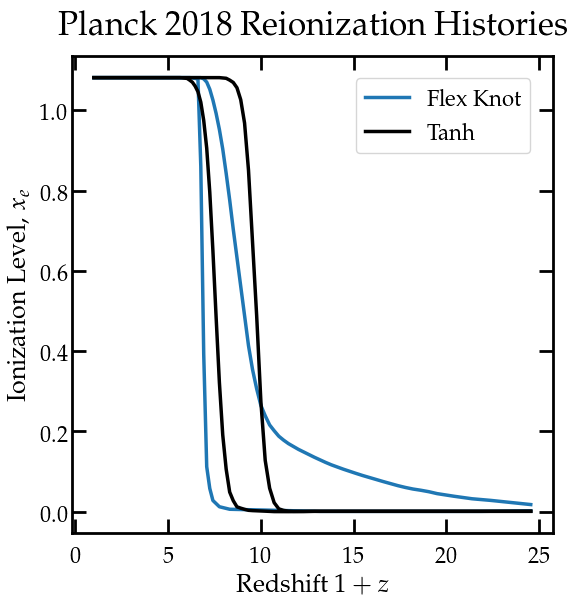

In [6]:
import darkhistory.history.reionization as reion
import csv
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']
)
def make_reion_interp_func(string):
    Planck_data = []
    with open('/Users/gridgway/Dropbox (MIT)/Late_Time_Energy_Injection/reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)
    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]

    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac
    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]
    Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
    return interp1d(Planck_data[:,0], Planck_data[:,1], bounds_error=False, fill_value=(1+phys.chi,0))

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
# Plot the different methods
reion_rs_list = 10**np.arange(0,np.log10(25), .01)
colors = {'FlexKnot_early': 'C0',
         'FlexKnot_late': 'C0',
         'Tanh_early': 'k',
         'Tanh_late': 'k'}

plt.figure()
for string in reion_strings[2:]:
    if string[-4:] == 'late':
        plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string])
    else:
        if string[:-6] == 'FlexKnot':
            plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string], label='Flex Knot')
        else:
            plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string], label='Tanh')
plt.legend()
plt.xlabel(r'Redshift $1+z$')
plt.ylabel(r'Ionization Level, $x_e$')
plt.title(r'Planck 2018 Reionization Histories')
plt.show()

In [248]:
def zero_rate(rs):
    return 0
zero_rates = np.array([zero_rate, zero_rate, zero_rate])

In [10]:
rs_0 = rs_entries[0]-.1
chisq = True
Tm_max=5e4

In [316]:
%autoreload
def get_T_decay(mDM, tau, br, pri, constraint_type, chisq=False, reion_method = 'Puchwein', heat_switch=False, DeltaT=0):
    """Gets the temperature at z = 17, decays.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    tau : float
        The decay lifetime in s. 
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature in K at z = 17. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 12
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 4
        
        
    if br:
        
        #Use for robust constraints
        def zero_rate(rs):
            return 0
        zero_rates = np.array([zero_rate, zero_rate, zero_rate])
    
        if constraint_type == 'robust_noreion':
            result = main.evolve(
                primary=pri_str,
                DM_process=DM_process, mDM=mDM, lifetime=tau,
                start_rs = 3000, end_rs=end_rs,
                coarsen_factor=cf, backreaction=True,
                reion_switch=True, reion_method=None, heat_switch=False,
                photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs,
                helium_TLA=True
            )
        elif constraint_type == 'robust_reion':
            
            result = main.evolve(
                    primary=pri_str,
                    DM_process=DM_process, mDM=mDM, lifetime=tau,
                    start_rs = 3000, end_rs=end_rs,
                    coarsen_factor=cf, backreaction=True,
                    reion_switch=True, reion_method=None, heat_switch=heat_switch, 
                    xe_reion_func=reion_interps[reion_method],
                    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
                    helium_TLA=True
                )
        elif constraint_type == 'DeltaT':

            result = main.evolve(
                primary=pri_str,
                DM_process=DM_process, mDM=mDM, lifetime=tau,
                start_rs = 3000, end_rs=end_rs,
                coarsen_factor=cf, backreaction=True,
                reion_switch=True, reion_method=None, heat_switch=False, DeltaT=DeltaT,
                xe_reion_func=reion_interps[reion_method],
                photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
                helium_TLA=True
            )
            
        elif constraint_type == '2016_comparison':
            result = main.evolve(
                DM_process = 'decay',
                mDM = mDM,
                lifetime = tau,
                primary = pri_str,
                start_rs = 3000,
                reion_switch = True,
                reion_rs = 7,
                compute_fs_method = 'HeII',
                helium_TLA = True,
                backreaction = True,
                coarsen_factor =cf,
                cross_check = False,
                end_rs=5.8
            )
        else:
            raise TypeError('Invalid reion_method for robust_reion constraint type')
                

        
        if not chisq:
            return result['Tm'][-1]/phys.kB
        else:
            return interp1d(result['rs'], result['Tm']/phys.kB)(rs_entries)
    
    else:
        # get_history takes a redshift vector 
                            
        rs_vec = np.flipud(np.arange(end_rs, 2700., 0.1))
        
        if constraint_type == '2016_comparison':
            result = main.evolve(
                DM_process = 'decay',
                mDM = mDM,
                lifetime = tau,
                primary = pri_str,
                start_rs = 3000,
                reion_switch = True,
                reion_rs = 7,
                compute_fs_method = 'HeII',
                helium_TLA = True,
                backreaction = False,
                coarsen_factor =cf,
                cross_check = True,
                end_rs=end_rs
            )
        else:
            result = get_history(
                rs_vec, baseline_f = True,
                inj_particle = pri, DM_process = 'decay',
                mDM=mDM, lifetime = tau
            )

        if not chisq:
            if br or constraint_type == '2016_comparison':
                return result['Tm'][-1]/phys.kB
            else:
                return result[-1,0]/phys.kB
        else:
            return interp1d(rs_vec, result[:,0]/phys.kB)(rs_entries)

In [629]:
result = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=10**log10_m_chi_arr[0], lifetime=10**log10_tau_arr[20],
    start_rs = 3000, end_rs=rs_0, compute_fs_method = 'no_He',
    coarsen_factor=4, backreaction=True,
    reion_switch=True, reion_method=None, heat_switch=False,
    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = 30,
    helium_TLA=True
)

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


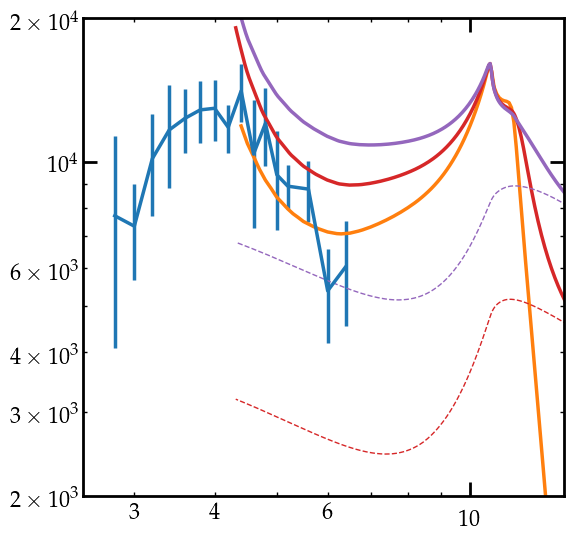

In [239]:
plt.figure()
plt.loglog()
plt.axis([2.5,14,2e3,2e4])
# plt.plot(rs_vec, phys.Tm_std(rs_vec)/phys.kB)
# plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, linestyle = '--', color='k')
# plt.plot(rs_vec[:-6], tmp_middle_half[:,0]/phys.kB)
plt.errorbar(1+mids[:,0], mids[:,1]*1e4, yerr=sigs*1e4)
# plt.plot(rs_vec[:-6], tmp_middle[:,0]/phys.kB)
plt.plot(rs_vec, tmp_early_half[:,0]/phys.kB)
plt.plot(result['rs'], result['Tm']/phys.kB, linestyle='--', color='C3', linewidth=1)
plt.plot(result['rs'], result_4e22_heat['Tm']/phys.kB, color='C3')

plt.plot(result['rs'], result_2e22['Tm']/phys.kB, linestyle='--', color='C4', linewidth=1)
plt.plot(result['rs'], result_2e22_heat['Tm']/phys.kB, color='C4')
plt.show()

Let's start the scan! To do the scan quickly, we'll first run the case with no backreaction first, and then use the results as an initial guess for [*main.evolve()*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). 

In [7]:
z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[-8:]

new_mids=[.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599]
mids = new_mids[-8:]


errs = [.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15]
sigs = errs[-8:]

In [16]:
%autoreload
DeltaT = 1e3*phys.kB
mDM=1e7
lifetime = 2*10**24
DM_process='decay'
end_rs=4.01
reion_rs=35
cf=4
pri='phot_delta'

tmp = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=reion_interps['Tanh_early'],
    coarsen_factor=cf, backreaction=True,
    compute_fs_method='no_He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

In [69]:
%autoreload
DeltaT = 0*phys.kB
mDM=1e4
lifetime = 2e24
DM_process='decay'
end_rs=4.01
reion_rs=7
cf=4
pri='phot_delta'

data_noRe_noBR_noHeII = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=False, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=False,
    compute_fs_method='no_He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

data_Re_noBR_HeII = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=False,
    compute_fs_method='HeII', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

%autoreload
data_noRe_BR_noHeII = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=True,
    compute_fs_method='no_He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

%autoreload
data_noRe_BR_HeII = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=True,
    compute_fs_method='HeII', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [89]:
%autoreload
data_Re_noBR_HII = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=False,
    compute_fs_method='HeII', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

In [95]:
%autoreload
data_Re_BR_HII = main.evolve(
    primary=pri_str,
    DM_process=DM_process, mDM=mDM, lifetime=lifetime,
    start_rs = 3e3, end_rs=end_rs, helium_TLA=True,
    reion_switch=True, reion_rs=reion_rs, reion_method=None, heat_switch=False, DeltaT = DeltaT,
    xe_reion_func=None,
    coarsen_factor=cf, backreaction=True,
    compute_fs_method='HeII', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check=False
)

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


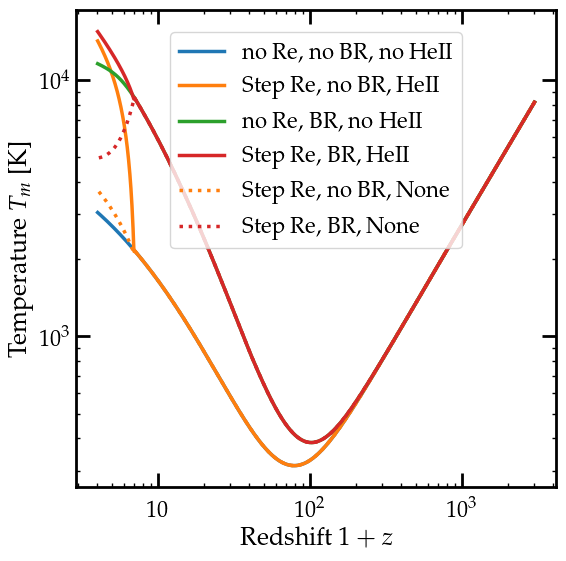

In [87]:
plt.figure()
plt.loglog()
plt.plot(data_noRe_noBR_noHeII['rs'], data_noRe_noBR_noHeII['Tm']/phys.kB, label='no Re, no BR, no HeII')
plt.plot(data_Re_noBR_HeII['rs'], data_Re_noBR_HeII['Tm']/phys.kB, label='Step Re, no BR, HeII')
plt.plot(data_noRe_BR_noHeII['rs'], data_noRe_BR_noHeII['Tm']/phys.kB, label='no Re, BR, no HeII')
plt.plot(data_Re_BR_HeII['rs'], data_Re_BR_HeII['Tm']/phys.kB, label='Step Re, BR, HeII')

# plt.plot(data_Re_noBR_None['rs'], data_Re_noBR_None['Tm']/phys.kB, label='Step Re, no BR, None', color='C1', linestyle = ':')
# plt.plot(data_Re_BR_None['rs'], data_Re_BR_None['Tm']/phys.kB, label='Step Re, BR, None', color='C3', linestyle = ':')


plt.xlabel(r'Redshift $1+z$')
plt.ylabel(r'Temperature $T_m$ [K]')
plt.legend()
plt.show()

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


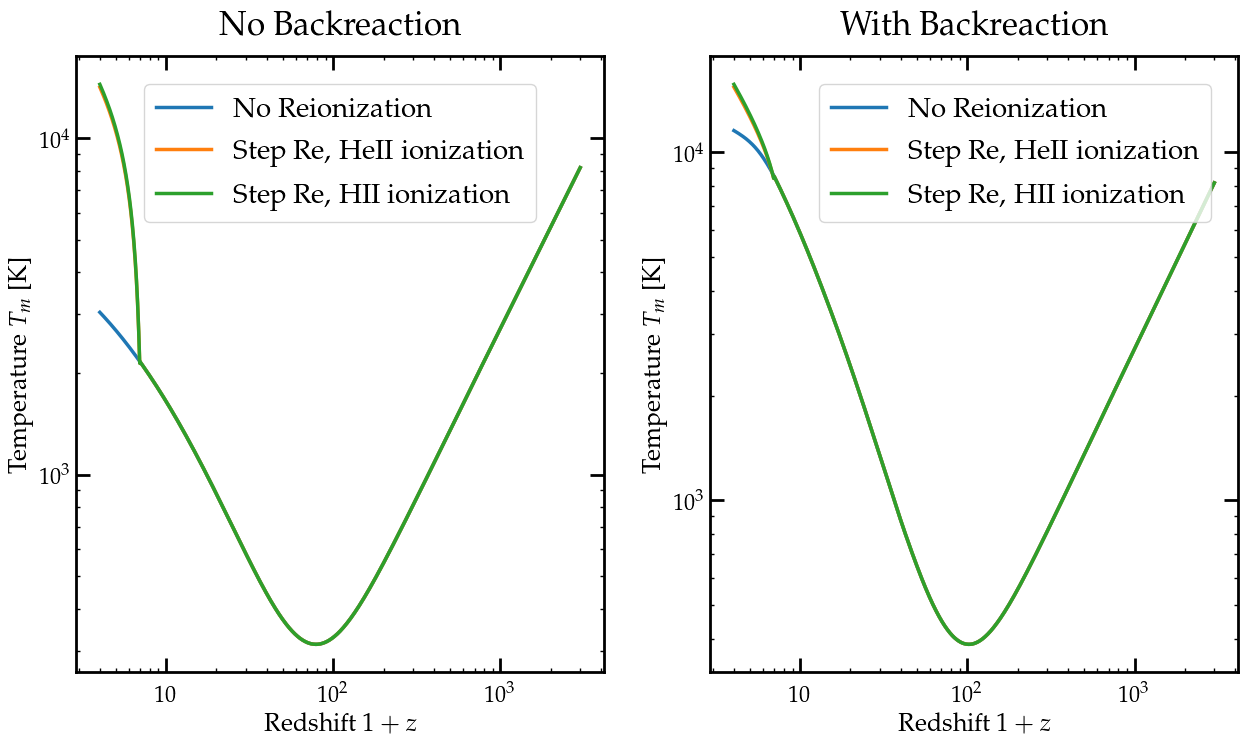

In [313]:
fig, axarr = plt.subplots(1, 2, figsize=(15,8))
# fig.suptitle("Different Photoionization Methods", fontsize=24)

axarr[0].loglog()
axarr[0].plot(data_noRe_noBR_noHeII['rs'], data_noRe_noBR_noHeII['Tm']/phys.kB, label='No Reionization')
axarr[0].plot(data_Re_noBR_HeII['rs'], data_Re_noBR_HeII['Tm']/phys.kB, label='Step Re, HeII ionization')
axarr[0].plot(data_Re_noBR_HII['rs'], data_Re_noBR_HII['Tm']/phys.kB, label='Step Re, HII ionization')
# axarr[0].plot(data_Re_noBR_None['rs'], data_Re_noBR_None['Tm']/phys.kB, label='Step Re, None', color='C1', linestyle = ':')
# plt.plot(data_noRe_BR_noHeII['rs'], data_noRe_BR_noHeII['Tm']/phys.kB, label='no Re, BR, no HeII')
# plt.plot(data_Re_BR_HeII['rs'], data_Re_BR_HeII['Tm']/phys.kB, label='Step Re, BR, HeII')

# plt.plot(data_Re_noBR_None['rs'], data_Re_noBR_None['Tm']/phys.kB, label='Step Re, no BR, None', color='C1', linestyle = ':')
# plt.plot(data_Re_BR_None['rs'], data_Re_BR_None['Tm']/phys.kB, label='Step Re, BR, None', color='C3', linestyle = ':')

axarr[0].set_xlabel(r'Redshift $1+z$')
axarr[0].set_ylabel(r'Temperature $T_m$ [K]')
leg1=axarr[0].legend(fontsize=20)
axarr[0].set_title('No Backreaction')


axarr[1].loglog()
axarr[1].plot(data_noRe_BR_noHeII['rs'], data_noRe_BR_noHeII['Tm']/phys.kB, label='No Reionization')
axarr[1].plot(data_Re_BR_HeII['rs'], data_Re_BR_HeII['Tm']/phys.kB, label='Step Re, HeII ionization')
axarr[1].plot(data_Re_BR_HII['rs'], data_Re_BR_HII['Tm']/phys.kB, label='Step Re, HII ionization')
# axarr[1].plot(data_Re_BR_None['rs'], data_Re_BR_None['Tm']/phys.kB, label='Step Re, BR, None', color='C3', linestyle = ':')

axarr[1].set_xlabel(r'Redshift $1+z$')
axarr[1].set_ylabel(r'Temperature $T_m$ [K]')
leg2 = axarr[1].legend(fontsize=20)
axarr[1].set_title('With Backreaction')
plt.savefig('/Users/gridgway/Dropbox (MIT)/Late_Time_Energy_Injection/figs/Helium_and_2016_method_mDM1e4_tau2e24.pdf')
plt.show()

In [318]:
pri='elec'
chisq=True
%autoreload
DeltaT = 0*phys.kB

DM_process='decay'
reion_rs=35

pri_str = pri+'_delta'

end_rs=4.01
Tm_max = 10000

In [369]:
%autoreload
br=True
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='DeltaT'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
    
elif constraint_type == 'DeltaT':
    constr_str='log10DeltaT_'+str(np.log10(DeltaT))
    
else:
    constr_str=constraint_type
    
if br == True:
    br_str='BR'
else:
    br_str='noBR'

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(19.5, 26, 0.25)

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size, rs_entries.size))

j = -11
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

    #         print('****************************')
            tau = 10**log10_tau_arr[j]
            print('log10tau: '+str(log10_tau_arr[j]))

            Tm_list[i,j] = get_T_decay(
                mDM, tau, br=br, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                heat_switch=heat_switch, DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))
                print(Tm_list[i,j])

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= 1

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += 1
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= 1
                elif reduced < 2:
                    below_target = True
                    j -= 1
                elif reduced > 2:
                    above_target = True
                    j+=1

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
            
            photoion_str='_HII_HeII'
            if DeltaT>0:
                pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+photoion_str+'.dat','wb'))
            else:
                pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_DeltaT_0'+photoion_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_'+br_str+'.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Reduced chi^2: 2  ######


/Users/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


****** log10(mDM):  6.01  ******
log10tau: 23.25


one-sided reduced chi^2: 1.3e+00
[9892.52735139 9442.60233814 9024.29514017 8638.83640168 8291.29558477
 7671.72524119 7164.9215251  6749.965626  ]
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 1.6e+01
[17881.96142921 17054.70911542 16280.90632899 15562.57650697
 14908.41458332 13723.47082513 12718.24206409 11851.79194325]
###### Calculation Complete! ######
****** log10(mDM):  6.51  ******
log10tau: 23.25


one-sided reduced chi^2: 7.5e+03
[169377.59691774 160046.85189546 151964.6229517  144862.13017547
 138589.016247   127969.37451179 119293.12910154 112051.29421859]
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 5.0e+03
[136184.21441196 129878.01831606 124314.24682585 119344.57203947
 114886.51038658 107180.91772733 100719.50208869  95190.30768038]
###### Calculation Complete! ######
log10tau: 23.75



one-sided reduced chi^2: 3.5e+03
[112687.54463069 108126.77684896 104038.05567628 100331.54593613
  96957.00016711  90997.80620529  85843.07041528  81217.73676107]
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 2.4e+03
[94760.65034301 91233.88872073 88012.02812144 85032.89126693
 82255.18247414 77095.79209079 71989.45167883 65789.34058381]
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 1.4e+03
[79463.21151722 76297.30293181 73180.32467714 70009.40906513
 66658.94912615 59159.40450533 50936.16220778 42937.34094175]
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 4.7e+02
[59776.94060287 55099.64029613 50527.61653709 46196.14643403
 42199.00141485 35276.92731084 29648.20425061 25070.29321109]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 9.0e+01
[34622.47198888 31284.3166583  28340.98458409 25727.74486622
 23408.05810874 19489.14352133 16337.9316004  13784.43591566]
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 6.4e+00
[19150.73520241 17274.8688305  15623.47283117 14158.65859919
 12859.50487963 10667.63599677  8908.53167206  7486.35776932]
###### Calculation Complete! ######
log10tau: 25.25


one-sided reduced chi^2: 0.0e+00
[10520.04526247  9469.08500158  8544.83107807  7725.91170054
  7000.51520121  5779.16077688  4802.27178957  4015.69910634]
###### Calculation Complete! ######
****** log10(mDM):  7.01  ******
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
[9612.21280879 8570.00684548 7663.2835139  6867.73365928 6169.67244956
 5009.08261846 4094.87573788 3368.3388891 ]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 2.6e+00
[17507.99603042 15646.52318537 14025.1361486  12600.7715324
 11349.2140491   9263.17257353  7613.4626023   6296.10828666]
###### Calculation Complete! ######
****** log10(mDM):  7.51  ******
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
[3322.07387639 2961.7019184  2653.78598113 2389.13931471 2162.74755605
 1803.99448254 1546.93465479 1372.62028185]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 0.0e+00
[6173.91366134 5526.86423009 4972.72804113 4495.18454453 4085.38878437
 3432.23671386 2958.7088239  2630.44405563]
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 1.8e-02
[11306.58275945 10146.39344274  9150.5009913   8290.07113857
  7549.24760264  6361.24142269  5489.3780957   4872.05016777]
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 1.0e+01
[20489.29399729 18410.47556926 16622.10756689 15072.94289078
 13734.71772887 11575.06785537  9969.79071093  8808.5303074 ]
###### Calculation Complete! ######
****** log10(mDM):  8.01  ******
log10tau: 24.5


one-sided reduced chi^2: 1.4e+01
[16108.89564712 15539.06388727 15021.347009   14552.48366557
 14132.36398136 13434.44367568 12927.92212099 12624.62002366]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 3.0e+00
[9135.30659598 8856.44057662 8611.78006289 8399.54470051 8220.4680351
 7961.85890613 7841.79986397 7874.73546151]
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
[5161.11811478 5031.57295682 4924.93128915 4840.3902352  4778.84670354
 4726.41912548 4775.07841991 4938.71377168]
###### Calculation Complete! ######
****** log10(mDM):  8.51  ******
log10tau: 24.75


one-sided reduced chi^2: 1.8e+02
[39160.58791489 36371.1879315  33836.43296452 31528.7450181
 29436.64867392 25807.17296242 22812.32815379 20351.33791153]
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 2.6e+01
[22028.04671335 20492.85303002 19113.34270777 17869.76986082
 16754.44545253 14855.88998221 13344.27539777 12169.77614179]
###### Calculation Complete! ######
log10tau: 25.25


one-sided reduced chi^2: 8.3e-01
[12216.66305897 11370.26122283 10613.26883288  9934.6383975
  9330.24128881  8315.1211385   7528.08612548  6943.34382667]
###### Calculation Complete! ######
****** log10(mDM):  9.01  ******
log10tau: 25.0


one-sided reduced chi^2: 7.4e-01
[13371.69744488 12235.63141709 11234.24616145 10347.0712047
  9564.65174107  8259.52297324  7244.14294907  6466.89410698]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 3.1e+01
[24278.78593582 22251.07522646 20461.72959692 18874.49554593
 17472.52729263 15127.63742228 13294.36413958 11880.87330505]
###### Calculation Complete! ######
****** log10(mDM):  9.51  ******
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
[4408.30522736 4004.56704744 3650.00587482 3336.99659571 3061.93387118
 2605.22107918 2252.01363689 1983.00058733]
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 0.0e+00
[8169.64810173 7449.13907393 6815.69134513 6255.84353266 5763.26538001
 4943.82576638 4308.25845886 3822.48452731]
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 1.5e+00
[14960.38849467 13676.54712155 12547.03238485 11548.02929524
 10668.35597421  9203.17497874  8064.81953211  7193.26739672]
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 4.7e+01
[27084.58127308 24788.82612513 22765.74031623 20973.08204593
 19390.91108308 16744.57060679 14672.12718285 13065.91176452]
###### Calculation Complete! ######
****** log10(mDM):  10.01  ******
log10tau: 24.5


one-sided reduced chi^2: 0.0e+00
[4534.92753573 4131.27621817 3775.97389597 3461.70787545 3185.16326395
 2724.33606231 2366.52218578 2092.42242745]
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 0.0e+00
[8400.48619712 7680.44721381 7045.97499022 6484.17096039 5989.21808756
 5162.89802116 4519.48735122 4024.93107467]
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 2.2e+00
[15377.73622491 14094.9056432  12963.73145441 11961.39350214
 11077.62381876  9600.41213103  8448.24237887  7561.13516116]
###### Calculation Complete! ######
****** log10(mDM):  10.51  ******
log10tau: 24.25


one-sided reduced chi^2: 0.0e+00
[2669.63274532 2425.41693933 2210.22102808 2019.79852589 1852.31164488
 1573.03163844 1356.37067691 1190.51515978]
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 0.0e+00
[5011.62472068 4574.78466909 4189.19995724 3847.40762094 3546.20189148
 3042.41245556 2649.69852227 2347.2022814 ]
###### Calculation Complete! ######
log10tau: 23.75


one-sided reduced chi^2: 0.0e+00
[9262.747736   8483.72691192 7795.39582526 7184.6032177  6645.7189658
 5742.72852259 5036.85878771 4491.29819553]
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 4.8e+00
[16928.37595707 15540.30764342 14312.95914437 13223.03930357
 12260.62410993 10645.7429205   9380.92482977  8401.26428954]
###### Calculation Complete! ######
****** log10(mDM):  11.01  ******
log10tau: 23.75


one-sided reduced chi^2: 0.0e+00
[2710.43044323 2469.0353861  2256.62814793 2069.04555959 1904.53447856
 1631.56906166 1422.10582165 1264.71739172]
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 0.0e+00
[5090.48568994 4659.29572433 4279.33125997 3943.27351998 3648.06899056
 3156.99307229 2778.63513488 2492.75301749]
###### Calculation Complete! ######
log10tau: 23.25


one-sided reduced chi^2: 0.0e+00
[9407.21677563 8638.61204048 7960.66768715 7360.45999369 6832.63712467
 5953.0247392  5273.42657376 4757.83047488]
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 5.9e+00
[17181.19188089 15810.69395542 14600.75487091 13528.49470352
 12584.45146757 11008.06943134  9786.26544259  8855.55800949]
###### Calculation Complete! ######
****** log10(mDM):  11.51  ******
log10tau: 23.25


one-sided reduced chi^2: 0.0e+00
[2983.28435619 2741.71795398 2528.74786142 2340.42945966 2175.20017487
 1901.2866345  1692.45384418 1539.84920242]
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 0.0e+00
[5594.75000233 5164.51295306 4784.77231274 4448.59954285 4153.27895815
 3662.72871859 3287.51726274 3011.28543012]
###### Calculation Complete! ######
log10tau: 22.75


one-sided reduced chi^2: 5.3e-01
[10323.74637234  9557.93867168  8881.49009883  8282.17515972
  7755.24783823  6878.78370498  6207.00956828  5707.4898248 ]
###### Calculation Complete! ######
log10tau: 22.5


one-sided reduced chi^2: 1.2e+01
[18757.80049191 17383.01907289 16165.52370455 15083.60023362
 14128.72577686 12529.18486005 11286.24044014 10340.13141706]
###### Calculation Complete! ######
****** log10(mDM):  12.01  ******
log10tau: 22.75


one-sided reduced chi^2: 0.0e+00
[3558.65603027 3287.56795937 3047.68717579 2834.85450997 2647.50528133
 2335.64020061 2097.26325322 1922.72054572]
###### Calculation Complete! ######
log10tau: 22.5


one-sided reduced chi^2: 0.0e+00
[6642.41639452 6160.26002038 5733.18101678 5353.87380164 5019.62328394
 4462.23933979 4034.34432194 3718.54968484]
###### Calculation Complete! ######
log10tau: 22.25


one-sided reduced chi^2: 8.5e-01
[12214.24651757 11355.93296436 10595.10311932  9918.85283126
  9322.43401191  8326.50956323  7559.89856691  6987.85025803]
###### Calculation Complete! ######
log10tau: 22.0


one-sided reduced chi^2: 2.7e+01
[22020.95792237 20464.29084    19077.5631508  17837.74011794
 16736.03118992 14870.249673   13393.32391483 12239.28854565]
###### Calculation Complete! ######
****** log10(mDM):  12.51  ******
log10tau: 22.25


one-sided reduced chi^2: 0.0e+00
[3797.77484028 3517.01972978 3268.20434188 3047.14472438 2852.31510181
 2527.50366778 2279.23058727 2097.48869964]
###### Calculation Complete! ######
log10tau: 22.0


one-sided reduced chi^2: 0.0e+00
[7076.08275844 6576.8647656  6133.98789397 5740.10258793 5392.56247402
 4812.05577065 4365.94227774 4036.34702299]
###### Calculation Complete! ######
log10tau: 21.75


one-sided reduced chi^2: 1.4e+00
[12992.58149336 12103.33509738 11313.69646627 10610.7498916
  9989.85850898  8950.90191578  8149.0900014   7549.21074984]
###### Calculation Complete! ######
log10tau: 21.5


one-sided reduced chi^2: 3.4e+01
[23357.58791536 21737.63880554 20290.66679844 18993.43321018
 17837.22228889 15869.45238151 14298.88568492 13057.53090319]
###### Calculation Complete! ######


In [362]:
Tm_elec_DeltaT_0_HII[0,-12:-10]

array([[17882.43168152, 17055.15495585, 16281.32880145, 15562.97648328,
        14908.79284895, 13723.80710553, 12718.53735677, 11852.04580896],
       [ 9892.78781796,  9442.8493717 ,  9024.529337  ,  8639.05826925,
         8291.5056004 ,  7671.91238207,  7165.08607138,  6750.10727996]])

In [321]:
%autoreload
br=True
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='DeltaT'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
    
elif constraint_type == 'DeltaT':
    constr_str='log10DeltaT_'+str(np.log10(DeltaT))
    
else:
    constr_str=constraint_type
    
if br == True:
    br_str='BR'
else:
    br_str='noBR'

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(19.5, 26, 0.25)

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size, rs_entries.size))

j = -11
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

    #         print('****************************')
            tau = 10**log10_tau_arr[j]
            print('log10tau: '+str(log10_tau_arr[j]))

            Tm_list[i,j] = get_T_decay(
                mDM, tau, br=br, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                heat_switch=heat_switch, DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= 1

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += 1
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= 1
                elif reduced < 2:
                    below_target = True
                    j -= 1
                elif reduced > 2:
                    above_target = True
                    j+=1

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
            
            photoion_str='_HII'
            if DeltaT>0:
                pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+photoion_str+'.dat','wb'))
            else:
                pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_DeltaT_0'+photoion_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_'+br_str+'.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Reduced chi^2: 2  ######


/Users/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


****** log10(mDM):  6.01  ******
log10tau: 23.25


Exception in thread Thread-21:
Traceback (most recent call last):
  File "/Users/gridgway/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/gridgway/anaconda3/lib/python3.6/site-packages/tqdm-4.19.5-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/gridgway/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



one-sided reduced chi^2: 1.3e+00
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 1.6e+01
###### Calculation Complete! ######
****** log10(mDM):  6.51  ******
log10tau: 23.25


one-sided reduced chi^2: 7.5e+03
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 5.0e+03
###### Calculation Complete! ######
log10tau: 23.75


one-sided reduced chi^2: 3.5e+03
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 2.4e+03
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 1.4e+03
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 4.7e+02
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 9.0e+01
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 6.4e+00
###### Calculation Complete! ######
log10tau: 25.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
****** log10(mDM):  7.01  ******
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 2.6e+00
###### Calculation Complete! ######
****** log10(mDM):  7.51  ******
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 4.7e-01
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 2.2e+01
###### Calculation Complete! ######
****** log10(mDM):  8.01  ******
log10tau: 24.5


one-sided reduced chi^2: 4.0e+02
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 7.9e+01
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 6.7e+00
###### Calculation Complete! ######
log10tau: 25.25


one-sided reduced chi^2: 1.2e-01
###### Calculation Complete! ######
****** log10(mDM):  8.51  ******
log10tau: 25.0


one-sided reduced chi^2: 8.4e+01
###### Calculation Complete! ######
log10tau: 25.25


one-sided reduced chi^2: 6.4e+00
###### Calculation Complete! ######
log10tau: 25.5


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
****** log10(mDM):  9.01  ******
log10tau: 25.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 3.5e+00
###### Calculation Complete! ######
****** log10(mDM):  9.51  ******
log10tau: 25.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 25.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.75


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 7.1e+00
###### Calculation Complete! ######
****** log10(mDM):  10.01  ******
log10tau: 24.75


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.5


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.25


one-sided reduced chi^2: 1.6e-04
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 8.4e+00
###### Calculation Complete! ######
****** log10(mDM):  10.51  ******
log10tau: 24.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 24.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 23.75


one-sided reduced chi^2: 2.2e-01
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 1.4e+01
###### Calculation Complete! ######
****** log10(mDM):  11.01  ******
log10tau: 23.75


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 23.5


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 23.25


one-sided reduced chi^2: 2.6e-01
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 1.6e+01
###### Calculation Complete! ######
****** log10(mDM):  11.51  ******
log10tau: 23.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 23.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 22.75


one-sided reduced chi^2: 7.2e-01
###### Calculation Complete! ######
log10tau: 22.5


one-sided reduced chi^2: 2.9e+01
###### Calculation Complete! ######
****** log10(mDM):  12.01  ******
log10tau: 22.75


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 22.5


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 22.25


one-sided reduced chi^2: 2.7e+00
###### Calculation Complete! ######
****** log10(mDM):  12.51  ******
log10tau: 22.5


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 22.25


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 22.0


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10tau: 21.75


one-sided reduced chi^2: 4.6e+00
###### Calculation Complete! ######


In [367]:
Tm_elec_DeltaT_0_HII[1,-11:-1]

array([[169377.60103617, 160046.85582904, 151964.62673906,
        144862.13384339, 138589.019825  , 127969.3779731 ,
        119293.13251249, 112051.29763694],
       [136184.21721263, 129878.02104402, 124314.24949926,
        119344.57467132, 114886.51299339, 107180.92031961,
        100719.50470929,  95190.31037202],
       [112687.54671958, 108126.77892021, 104038.05774052,
        100331.54800244,  96957.00224749,  90997.80834295,
         85843.07265992,  81217.73920869],
       [ 94760.65203382,  91233.89043379,  88012.02986881,
         85032.8930632 ,  82255.18434223,  77095.79421224,
         71989.45438053,  65789.34445732],
       [ 79463.21320201,  76297.30479576,  73180.32680557,
         70009.41155969,  66658.95210454,  59159.40853012,
         50936.16677351,  42937.34527003],
       [ 59776.94391257,  55099.64391772,  50527.62030657,
         46196.15020704,  42199.00508857,  35276.93064172,
         29648.20718219,  25070.29572783],
       [ 34622.47460118,  31284.31

In [206]:
%autoreload
br=True
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='2016_comparison'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
    
elif constraint_type == 'DeltaT':
    constr_str='log10DeltaT_'+str(np.log10(DeltaT))
    
elif constraint_type == '2016_comparison':
    constr_str='2016_comparison'
    
if br == True:
    br_str='BR'
else:
    br_str='noBR'

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(19.5, 26, 0.25)

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size, rs_entries.size))

j = -7
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

    #         print('****************************')
            tau = 10**log10_tau_arr[j]
            print('log10tau: '+str(log10_tau_arr[j]))

            Tm_list[i,j] = get_T_decay(
                mDM, tau, br=br, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                heat_switch=heat_switch, DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= 1

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += 1
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= 1
                elif reduced < 2:
                    below_target = True
                    j -= 1
                elif reduced > 2:
                    above_target = True
                    j+=1
    #                 if j==0 or Tm_list[i,j,-1]>5e4:
    #                     j=log10_tau_arr.size-1
    #                     above_target=True
    #                     below_target=True
    #                 else:
    #                     j = j-1

                if heat_switch:
                    heat_str = 'photoheat'
                else:
                    heat_str = 'photoion'

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
    #                 pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_cooling.dat','wb'))
            if i>2:
                pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_'+br_str+'_HeII.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Temperature: 10000.0 K  ######


****** log10(mDM):  4.01  ******
log10tau: 24.25


lifetime: 1.8e+24  T(z = 17) w/o backreaction: 12292.4 K
###### Calculation Complete! ######
log10tau: 24.5


lifetime: 3.2e+24  T(z = 17) w/o backreaction: 6611.1 K
###### Calculation Complete! ######
****** log10(mDM):  4.51  ******
log10tau: 24.25


KeyboardInterrupt: 

In [352]:
DeltaT

0.0

In [197]:
Tm_list_BR_2016_HeII[0]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        , 12292.2891868 ,
        6610.93817126,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ])

In [219]:
%autoreload
br=False
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='2016_comparison'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
    
elif constraint_type == 'DeltaT':
    constr_str='log10DeltaT_'+str(np.log10(DeltaT))
    
elif constraint_type == '2016_comparison':
    constr_str='2016_comparison'
    
if br == True:
    br_str='BR'
else:
    br_str='noBR'

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(19.5, 26, 0.25)

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size, rs_entries.size))

j = -7
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

    #         print('****************************')
            tau = 10**log10_tau_arr[j]
            print('log10tau: '+str(log10_tau_arr[j]))

            Tm_list[i,j] = get_T_decay(
                mDM, tau, br=br, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                heat_switch=heat_switch, DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= 1

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += 1
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= 1
                elif reduced < 2:
                    below_target = True
                    j -= 1
                elif reduced > 2:
                    above_target = True
                    j+=1
    #                 if j==0 or Tm_list[i,j,-1]>5e4:
    #                     j=log10_tau_arr.size-1
    #                     above_target=True
    #                     below_target=True
    #                 else:
    #                     j = j-1

                if heat_switch:
                    heat_str = 'photoheat'
                else:
                    heat_str = 'photoion'

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
    #                 pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_cooling.dat','wb'))
            pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_'+br_str+'_CrossCheck.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Temperature: 10000.0 K  ######


****** log10(mDM):  4.01  ******
log10tau: 24.25
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+24  T(z = 17) w/o backreaction: 15984.7 K
###### Calculation Complete! ######
log10tau: 24.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+24  T(z = 17) w/o backreaction: 8820.9 K
###### Calculation Complete! ######
****** log10(mDM):  4.51  ******
log10tau: 24.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+24  T(z = 17) w/o backreaction: 1089.4 K
###### Calculation Complete! ######
log10tau: 24.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+24  T(z = 17) w/o backreaction: 2084.9 K
###### Calculation Complete! ######
log10tau: 23.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+23  T(z = 17) w/o backreaction: 3898.5 K
###### Calculation Complete! ######
log10tau: 23.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+23  T(z = 17) w/o backreaction: 7171.7 K
###### Calculation Complete! ######
log10tau: 23.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+23  T(z = 17) w/o backreaction: 13025.1 K
###### Calculation Complete! ######
****** log10(mDM):  5.01  ******
log10tau: 23.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+23  T(z = 17) w/o backreaction: 1642.0 K
###### Calculation Complete! ######
log10tau: 23.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+23  T(z = 17) w/o backreaction: 3089.7 K
###### Calculation Complete! ######
log10tau: 23.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+23  T(z = 17) w/o backreaction: 5695.0 K
###### Calculation Complete! ######
log10tau: 22.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+22  T(z = 17) w/o backreaction: 10341.4 K
###### Calculation Complete! ######
****** log10(mDM):  5.51  ******
log10tau: 23.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+23  T(z = 17) w/o backreaction: 8640.5 K
###### Calculation Complete! ######
log10tau: 22.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+22  T(z = 17) w/o backreaction: 15563.3 K
###### Calculation Complete! ######
****** log10(mDM):  6.01  ******
log10tau: 23.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+23  T(z = 17) w/o backreaction: 11001.5 K
###### Calculation Complete! ######
log10tau: 23.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+23  T(z = 17) w/o backreaction: 6053.1 K
###### Calculation Complete! ######
****** log10(mDM):  6.51  ******
log10tau: 23.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+23  T(z = 17) w/o backreaction: 8085.1 K
###### Calculation Complete! ######
log10tau: 22.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+22  T(z = 17) w/o backreaction: 14658.4 K
###### Calculation Complete! ######
****** log10(mDM):  7.01  ******
log10tau: 23.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+23  T(z = 17) w/o backreaction: 2950.8 K
###### Calculation Complete! ######
log10tau: 22.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+22  T(z = 17) w/o backreaction: 5463.4 K
###### Calculation Complete! ######
log10tau: 22.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+22  T(z = 17) w/o backreaction: 9985.8 K
###### Calculation Complete! ######
log10tau: 22.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+22  T(z = 17) w/o backreaction: 18098.5 K
###### Calculation Complete! ######
****** log10(mDM):  7.51  ******
log10tau: 22.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+22  T(z = 17) w/o backreaction: 2258.9 K
###### Calculation Complete! ######
log10tau: 22.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+22  T(z = 17) w/o backreaction: 4200.5 K
###### Calculation Complete! ######
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 7700.3 K
###### Calculation Complete! ######
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 13958.0 K
###### Calculation Complete! ######
****** log10(mDM):  8.01  ******
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 2457.8 K
###### Calculation Complete! ######
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 4382.1 K
###### Calculation Complete! ######
log10tau: 21.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+21  T(z = 17) w/o backreaction: 7720.2 K
###### Calculation Complete! ######
log10tau: 21.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+21  T(z = 17) w/o backreaction: 13673.0 K
###### Calculation Complete! ######
****** log10(mDM):  8.51  ******
log10tau: 21.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+21  T(z = 17) w/o backreaction: 19517.7 K
###### Calculation Complete! ######
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 11048.9 K
###### Calculation Complete! ######
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 6242.2 K
###### Calculation Complete! ######
****** log10(mDM):  9.01  ******
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 19341.4 K
###### Calculation Complete! ######
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 10829.2 K
###### Calculation Complete! ######
log10tau: 22.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+22  T(z = 17) w/o backreaction: 6015.2 K
###### Calculation Complete! ######
****** log10(mDM):  9.51  ******
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 7674.5 K
###### Calculation Complete! ######
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 13814.6 K
###### Calculation Complete! ######
****** log10(mDM):  10.01  ******
log10tau: 22.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+22  T(z = 17) w/o backreaction: 3396.2 K
###### Calculation Complete! ######
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 6244.3 K
###### Calculation Complete! ######
log10tau: 21.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+21  T(z = 17) w/o backreaction: 11306.6 K
###### Calculation Complete! ######
****** log10(mDM):  10.51  ******
log10tau: 21.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+21  T(z = 17) w/o backreaction: 2338.1 K
###### Calculation Complete! ######
log10tau: 21.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+21  T(z = 17) w/o backreaction: 4348.6 K
###### Calculation Complete! ######
log10tau: 21.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+21  T(z = 17) w/o backreaction: 7952.8 K
###### Calculation Complete! ######
log10tau: 21.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+21  T(z = 17) w/o backreaction: 14352.5 K
###### Calculation Complete! ######
****** log10(mDM):  11.01  ******
log10tau: 21.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+21  T(z = 17) w/o backreaction: 2859.4 K
###### Calculation Complete! ######
log10tau: 21.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+21  T(z = 17) w/o backreaction: 5284.5 K
###### Calculation Complete! ######
log10tau: 20.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+20  T(z = 17) w/o backreaction: 9622.9 K
###### Calculation Complete! ######
log10tau: 20.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+20  T(z = 17) w/o backreaction: 17346.1 K
###### Calculation Complete! ######
****** log10(mDM):  11.51  ******
log10tau: 20.75
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 5.6e+20  T(z = 17) w/o backreaction: 3675.6 K
###### Calculation Complete! ######
log10tau: 20.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+20  T(z = 17) w/o backreaction: 6738.2 K
###### Calculation Complete! ######
log10tau: 20.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+20  T(z = 17) w/o backreaction: 12182.6 K
###### Calculation Complete! ######
****** log10(mDM):  12.01  ******
log10tau: 20.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+20  T(z = 17) w/o backreaction: 4231.3 K
###### Calculation Complete! ######
log10tau: 20.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+20  T(z = 17) w/o backreaction: 7712.6 K
###### Calculation Complete! ######
log10tau: 20.0
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.0e+20  T(z = 17) w/o backreaction: 13880.0 K
###### Calculation Complete! ######
****** log10(mDM):  12.51  ******
log10tau: 20.25
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 1.8e+20  T(z = 17) w/o backreaction: 11242.2 K
###### Calculation Complete! ######
log10tau: 20.5
cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


lifetime: 3.2e+20  T(z = 17) w/o backreaction: 6251.6 K
###### Calculation Complete! ######



In [56]:
pri='phot'
chisq=True
%autoreload
DeltaT = 1e4*phys.kB
DM_process='decay'
end_rs=4.01
reion_rs=35
cf=4
pri_str='phot_delta'

In [57]:
%autoreload
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='DeltaT'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
elif constraint_type == 'DeltaT':
    constr_str=''

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(19.5, 26, 0.25)

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size, rs_entries.size))

j = -7
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

    #         print('****************************')
            tau = 10**log10_tau_arr[j]
            print('log10tau: '+str(log10_tau_arr[j]))

            Tm_list[i,j] = get_T_decay(
                mDM, tau, br=True, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                heat_switch=heat_switch,
                DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= 1

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += 1
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= 1
                elif reduced < 2:
                    below_target = True
                    j -= 1
                elif reduced > 2:
                    above_target = True
                    j+=1
    #                 if j==0 or Tm_list[i,j,-1]>5e4:
    #                     j=log10_tau_arr.size-1
    #                     above_target=True
    #                     below_target=True
    #                 else:
    #                     j = j-1

                if heat_switch:
                    heat_str = 'photoheat'
                else:
                    heat_str = 'photoion'

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
    #                 pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_cooling.dat','wb'))
            pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+'.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Reduced chi^2: 2  ######


****** log10(mDM):  4.01  ******
log10tau: 24.25
nice


one-sided reduced chi^2: 2.4e+01
###### Calculation Complete! ######
log10tau: 24.5
nice


one-sided reduced chi^2: 5.5e+00
###### Calculation Complete! ######
log10tau: 24.75
nice


one-sided reduced chi^2: 3.6e+00
###### Calculation Complete! ######
log10tau: 25.0
nice


one-sided reduced chi^2: 9.7e-01
###### Calculation Complete! ######
****** log10(mDM):  4.51  ******
log10tau: 24.75
nice


one-sided reduced chi^2: 3.8e-02
###### Calculation Complete! ######
log10tau: 24.5
nice


one-sided reduced chi^2: 1.1e-01
###### Calculation Complete! ######
log10tau: 24.25
nice


one-sided reduced chi^2: 1.9e-01
###### Calculation Complete! ######
log10tau: 24.0
nice


one-sided reduced chi^2: 6.9e-01
###### Calculation Complete! ######
log10tau: 23.75
nice


one-sided reduced chi^2: 2.6e+00
###### Calculation Complete! ######
****** log10(mDM):  5.01  ******
log10tau: 24.0
nice


one-sided reduced chi^2: 8.8e-02
###### Calculation Complete! ######
log10tau: 23.75
nice


one-sided reduced chi^2: 1.4e-01
###### Calculation Complete! ######
log10tau: 23.5
nice


one-sided reduced chi^2: 5.4e-01
###### Calculation Complete! ######
log10tau: 23.25
nice


one-sided reduced chi^2: 2.1e+00
###### Calculation Complete! ######
****** log10(mDM):  5.51  ******
log10tau: 23.5
nice


one-sided reduced chi^2: 1.5e+00
###### Calculation Complete! ######
log10tau: 23.25
nice


one-sided reduced chi^2: 5.4e+00
###### Calculation Complete! ######
****** log10(mDM):  6.01  ******
log10tau: 23.5
nice


one-sided reduced chi^2: 2.4e+00
###### Calculation Complete! ######
log10tau: 23.75
nice


one-sided reduced chi^2: 6.3e-01
###### Calculation Complete! ######
****** log10(mDM):  6.51  ******
log10tau: 23.5
nice


one-sided reduced chi^2: 1.0e+00
###### Calculation Complete! ######
log10tau: 23.25
nice


one-sided reduced chi^2: 3.8e+00
###### Calculation Complete! ######
****** log10(mDM):  7.01  ******
log10tau: 23.5
nice


one-sided reduced chi^2: 1.0e-01
###### Calculation Complete! ######
log10tau: 23.25
nice


one-sided reduced chi^2: 3.7e-01
###### Calculation Complete! ######
log10tau: 23.0
nice


one-sided reduced chi^2: 1.4e+00
###### Calculation Complete! ######
log10tau: 22.75
nice


one-sided reduced chi^2: 5.0e+00
###### Calculation Complete! ######
****** log10(mDM):  7.51  ******
log10tau: 23.0
nice


one-sided reduced chi^2: 1.1e-01
###### Calculation Complete! ######
log10tau: 22.75
nice


one-sided reduced chi^2: 1.9e-01
###### Calculation Complete! ######
log10tau: 22.5
nice


one-sided reduced chi^2: 7.0e-01
###### Calculation Complete! ######
log10tau: 22.25
nice


one-sided reduced chi^2: 2.7e+00
###### Calculation Complete! ######
****** log10(mDM):  8.01  ******
log10tau: 22.5
nice


one-sided reduced chi^2: 5.8e-01
###### Calculation Complete! ######
log10tau: 22.25
nice


one-sided reduced chi^2: 2.1e+00
###### Calculation Complete! ######
****** log10(mDM):  8.51  ******
log10tau: 22.5
nice


one-sided reduced chi^2: 2.9e+00
###### Calculation Complete! ######
log10tau: 22.75
nice


one-sided reduced chi^2: 8.3e-01
###### Calculation Complete! ######
****** log10(mDM):  9.01  ******
log10tau: 22.5
nice


one-sided reduced chi^2: 4.3e+00
###### Calculation Complete! ######
log10tau: 22.75
nice


one-sided reduced chi^2: 1.2e+00
###### Calculation Complete! ######
****** log10(mDM):  9.51  ******
log10tau: 22.5
nice


one-sided reduced chi^2: 1.5e+00
###### Calculation Complete! ######
log10tau: 22.25
nice


one-sided reduced chi^2: 5.5e+00
###### Calculation Complete! ######
****** log10(mDM):  10.01  ******
log10tau: 22.5
nice


one-sided reduced chi^2: 2.3e-01
###### Calculation Complete! ######
log10tau: 22.25
nice


one-sided reduced chi^2: 8.9e-01
###### Calculation Complete! ######
log10tau: 22.0
nice


one-sided reduced chi^2: 3.4e+00
###### Calculation Complete! ######
****** log10(mDM):  10.51  ******
log10tau: 22.25
nice


one-sided reduced chi^2: 1.1e-01
###### Calculation Complete! ######
log10tau: 22.0
nice


one-sided reduced chi^2: 4.0e-01
###### Calculation Complete! ######
log10tau: 21.75
nice


one-sided reduced chi^2: 1.5e+00
###### Calculation Complete! ######
log10tau: 21.5
nice


one-sided reduced chi^2: 5.7e+00
###### Calculation Complete! ######
****** log10(mDM):  11.01  ******
log10tau: 21.75
nice


one-sided reduced chi^2: 1.7e-01
###### Calculation Complete! ######
log10tau: 21.5
nice


one-sided reduced chi^2: 6.4e-01
###### Calculation Complete! ######
log10tau: 21.25
nice


one-sided reduced chi^2: 2.4e+00
###### Calculation Complete! ######
****** log10(mDM):  11.51  ******
log10tau: 21.5
nice


one-sided reduced chi^2: 8.9e-02
###### Calculation Complete! ######
log10tau: 21.25
nice


one-sided reduced chi^2: 3.3e-01
###### Calculation Complete! ######
log10tau: 21.0
nice


one-sided reduced chi^2: 1.3e+00
###### Calculation Complete! ######
log10tau: 20.75
nice


one-sided reduced chi^2: 4.8e+00
###### Calculation Complete! ######
****** log10(mDM):  12.01  ******
log10tau: 21.0
nice


one-sided reduced chi^2: 6.3e-01
###### Calculation Complete! ######
log10tau: 20.75
nice


one-sided reduced chi^2: 2.4e+00
###### Calculation Complete! ######
****** log10(mDM):  12.51  ******
log10tau: 21.0
nice


one-sided reduced chi^2: 2.1e+00
###### Calculation Complete! ######
log10tau: 21.25
nice


one-sided reduced chi^2: 5.5e-01
###### Calculation Complete! ######


In [60]:
Tm_dec_DeltaT_0 = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_DeltaT_0.dat','rb'))
DeltaT=1e3*phys.kB
Tm_dec_DeltaT_1e3 = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+'.dat','rb'))
DeltaT=1e4*phys.kB
Tm_dec_DeltaT_1e4 = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+'.dat','rb'))
min_lifetime_Tanh_late_DeltaT_0_chisq = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_dec_DeltaT_0, 2)

In [486]:
Tm_dec_br = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_Wenzer_Comparison.dat','rb'))
Tm_dec_no_br = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_no_br_Wenzer_Comparison.dat','rb'))
Tm_dec_photoion = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_photoion_Puchwein.dat','rb'))
Tm_dec_photoion_early = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_early_photoion.dat','rb'))
Tm_dec_photoion_middle = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_middle_photoion.dat','rb'))
Tm_dec_2016_comparison = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_2016_comparison.dat','rb'))
Tm_dec_2016_with_br = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_2016_method.dat','rb'))

In [221]:
Tm_list_noBR = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay___noBR.dat','rb'))
min_lifetime_noBR = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_noBR[:-2]]
)

Tm_list_noBR_2016_CrossCheck = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_2016_comparison__noBR_CrossCheck.dat','rb'))
min_lifetime_noBR_2016_CrossCheck = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_noBR_2016_CrossCheck]
)

Tm_list_BR = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_robust_noreion__BR.dat','rb'))
min_lifetime_BR = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_BR]
)

Tm_list_noBR_2016_HeII = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_2016_comparison__noBR_HeII.dat','rb'))
min_lifetime_noBR_2016_HeII = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_noBR_2016_HeII]
)

Tm_list_noBR_2016_HII = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_2016_comparison__noBR_HII.dat','rb'))
min_lifetime_noBR_2016_HII = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_noBR_2016_HII]
)

Tm_list_BR_2016_HeII = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_2016_comparison__BR_HeII.dat','rb'))
min_lifetime_BR_2016_HeII = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_BR_2016_HeII]
)

Tm_list_BR_2016_HII = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_phot_decay_2016_comparison__BR_HII.dat','rb'))
min_lifetime_BR_2016_HII = np.array(
    [get_log10_min_lifetime(np.arange(19.5, 26, 0.25), row, Tm_max) for row in Tm_list_BR_2016_HII]
)

In [54]:
Tm_list_chisq = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_chisq.dat','rb'))

Having obtained an (incomplete) list of temperature values, we write a simple function to perform a linear interpolation at each mass point to obtain the limit on the minimum lifetime, and then compute it in `min_lifetime_no_br`. 

In [107]:
pri='phot'
Tm_dec_no_br = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_no_br.dat','rb'))
Tm_dec_br = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br.dat','rb'))
Tm_dec_photoion = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_photoion.dat','rb'))
if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_tau_arr   = np.arange(18., 26, 0.25)

In [155]:
def get_log10_min_lifetime(log10_lifetime_arr, Tm_arr, max_Tm):
    """Returns the log10 minimum lifetime from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 lifetimes used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    # Find the last index at which we have Tm > max_Tm in Tm_arr. 
    above = np.where((Tm_arr > 0) & (Tm_arr > max_Tm))[0][-1]
    # Since increasing lifetime decreases Tm, the next index must
    # lie below max_Tm.
    below = above+1
    
    # Obtain the two temperature values. 
    Ts = [Tm_arr[below], Tm_arr[above]]
    # Obtain the two log10 lifetime values. 
    log10_taus = [log10_lifetime_arr[below], log10_lifetime_arr[above]]
    
    # Perform a linear interpolation.
    return (np.diff(log10_taus)/np.diff(Ts)*(max_Tm-Ts[0]) + log10_taus[0])[0]

# min_lifetime_no_br = np.array(
#     [get_log10_min_lifetime(np.arange(18, 26, 0.25), row, Tm_max) for row in Tm_dec_no_br]
# )
# min_lifetime_br = np.array(
#     [get_log10_min_lifetime(np.arange(18, 26, 0.25), row, Tm_max) for row in Tm_dec_br]
# )

# min_lifetime_photoion = np.array(
#     [get_log10_min_lifetime(np.arange(19.5, 24.75, 0.25), row, Tm_max) for row in Tm_dec_photoion[:-4]]
# )

# min_lifetime_photoion_early = np.array(
#     [get_log10_min_lifetime(np.arange(19.5, 24.75, 0.25), row, Tm_max) for row in Tm_dec_photoion_early]
# )

# min_lifetime_photoion_middle = np.array(
#     [get_log10_min_lifetime(np.arange(19.5, 24.75, 0.25), row, Tm_max) for row in Tm_dec_photoion_middle]
# )

# min_lifetime_2016_comparison = np.array(
#     [get_log10_min_lifetime(np.arange(19.5, 24.75, 0.25), row, Tm_max) for row in Tm_dec_2016_comparison]
# )

# min_lifetime_2016_with_br = np.array(
#     [get_log10_min_lifetime(np.arange(19.5, 24.75, 0.25), row, Tm_max) for row in Tm_dec_2016_with_br[:15]]
# )

In [ ]:
# Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_br_'+reion_method+'_184e-2_'+heat_str+'.dat','rb'))
Tm_list = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_robust_chisq_noreion.dat','rb'))

In [329]:
def get_log10_min_lifetime_chisq(log10_mDM_arr, log10_lifetime_arr, Tm_arr, max_reduced_chisq):
    """Returns the log10 minimum lifetime from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 lifetimes used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    
    i_len = log10_mDM_arr.size
    j_len = log10_lifetime_arr.size
    
    reduced_list = np.ones_like(Tm_arr[:,:,0])
    for i in np.arange(i_len):
        for j in np.arange(j_len):
            diff = Tm_arr[i,j]*1e-4 - mids
            diff[diff<0] = 0
            DoF = sum(diff>0)
            if DoF == 0:
                reduced_list[i,j] = 0
            else:
                reduced_list[i,j] = sum((diff/sigs)**2)/DoF
            

    below=np.array([
        np.where(reduced_list[i] == reduced_list[i][reduced_list[i]>max_reduced_chisq][-1])[0][0]+1 
        for i in np.arange(i_len)
    ])
    above = below-1
    
    # Obtain the two temperature values. 
    chis = np.array([[reduced_list[i][below[i]], reduced_list[i][above[i]]] for i in np.arange(i_len)])
    # Obtain the two log10 lifetime values. 
    log10_taus = np.array([[log10_lifetime_arr[below[i]], log10_lifetime_arr[above[i]]] for i in np.arange(i_len)])
    
    # Perform a linear interpolation.
    return (np.diff(log10_taus)/np.diff(chis)*(max_reduced_chisq-chis) + log10_taus)[:,0]

# pri='phot'
# constr_str='robust_reion_early'
# Tm_robust_reion_early_chisq = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_cooling.dat','rb'))
# constr_str='robust_reion_late'
# Tm_robust_reion_late_chisq = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_cooling.dat','rb'))

# Tm_robust_noreion_chisq = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_robust_chisq_noreion.dat','rb'))

# min_lifetime_robust_reion_late_chisq = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_robust_reion_late_chisq, 2)
# min_lifetime_robust_reion_early_chisq = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_robust_reion_early_chisq, 2)
# min_lifetime_robust_noreion_chisq = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_robust_noreion_chisq, 2)

Let's just make a simple plot to make sure we understand what we have.

In [158]:
import csv
constraint_data = []
with open('/Users/gridgway/Desktop/Hongwan2016_phot_decay.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         constraint_data.append([float(row[0]),float(row[1])])
constraint_data = np.array(constraint_data)

In [162]:
log10_m_chi_arr[:-2].shape

(16,)

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


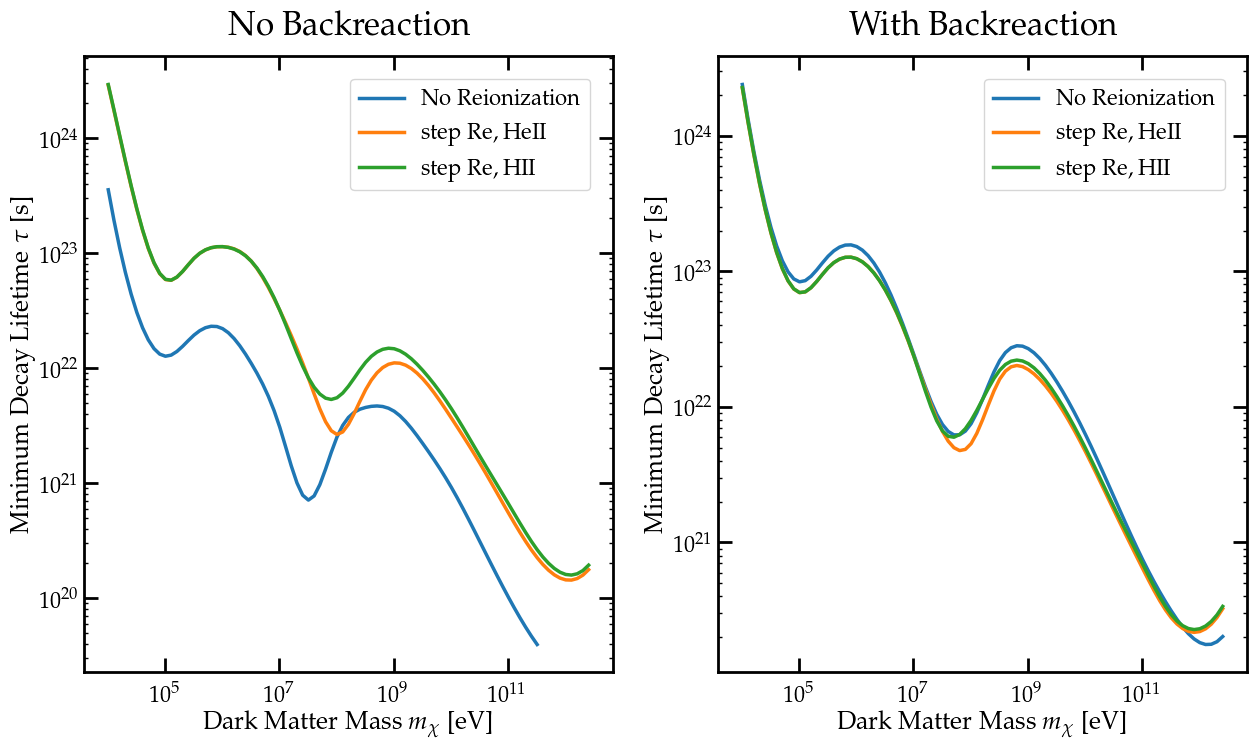

In [315]:
fig, axarr = plt.subplots(1, 2, figsize=(15,8))

log10_mDM_fine = np.arange(4.01,12.51,.1)

axarr[0].loglog()
ran = log10_mDM_fine<log10_m_chi_arr[-3]
axarr[0].plot(10**log10_mDM_fine[ran], 10**interp1d(log10_m_chi_arr[:-2],min_lifetime_noBR, kind='cubic')(log10_mDM_fine[ran])
         , label='No Reionization')
# plt.plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_noBR_2016_CrossCheck, kind='cubic')(log10_mDM_fine)
#          , label='Cross-Check')
axarr[0].plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_noBR_2016_HeII, kind='cubic')(log10_mDM_fine)
         , label='step Re, HeII')

axarr[0].plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_noBR_2016_HII, kind='cubic')(log10_mDM_fine)
         , label='step Re, HII')
# axarr[0].plot(constraint_data[:,0], constraint_data[:,1], color='k', linestyle = '--', label='2016 Constraint')
axarr[0].set_xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
axarr[0].set_ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
axarr[0].set_title('No Backreaction')
axarr[0].legend()


axarr[1].loglog()
axarr[1].plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_BR, kind='cubic')(log10_mDM_fine)
         , label='No Reionization')

axarr[1].plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_BR_2016_HeII, kind='cubic')(log10_mDM_fine)
         , label='step Re, HeII')

axarr[1].plot(10**log10_mDM_fine, 10**interp1d(log10_m_chi_arr,min_lifetime_BR_2016_HII, kind='cubic')(log10_mDM_fine)
         , label='step Re, HII')
axarr[1].set_xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
axarr[1].set_ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
axarr[1].set_title('With Backreaction')
axarr[1].legend()


# plt.axis([1e4,1e12,1e17,1e28])
# plt.title(r'$\chi \to \gamma \gamma$ Robust Limits')#, $T_m(z=3.2) = 10^4$ K')
# plt.ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
# plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

plt.savefig('/Users/gridgway/Dropbox (MIT)/Late_Time_Energy_Injection/figs/phot_decay_stepRe_at_z6_Helium_comparison.pdf')
plt.show()

In [ ]:

# fig.suptitle("Different Photoionization Methods", fontsize=24)

axarr[0].plot(data_noRe_noBR_noHeII['rs'], data_noRe_noBR_noHeII['Tm']/phys.kB, label='No Reionization')
axarr[0].plot(data_Re_noBR_HeII['rs'], data_Re_noBR_HeII['Tm']/phys.kB, label='Step Re, HeII ionization')
axarr[0].plot(data_Re_noBR_HII['rs'], data_Re_noBR_HII['Tm']/phys.kB, label='Step Re, HII ionization')
# axarr[0].plot(data_Re_noBR_None['rs'], data_Re_noBR_None['Tm']/phys.kB, label='Step Re, None', color='C1', linestyle = ':')
# plt.plot(data_noRe_BR_noHeII['rs'], data_noRe_BR_noHeII['Tm']/phys.kB, label='no Re, BR, no HeII')
# plt.plot(data_Re_BR_HeII['rs'], data_Re_BR_HeII['Tm']/phys.kB, label='Step Re, BR, HeII')

# plt.plot(data_Re_noBR_None['rs'], data_Re_noBR_None['Tm']/phys.kB, label='Step Re, no BR, None', color='C1', linestyle = ':')
# plt.plot(data_Re_BR_None['rs'], data_Re_BR_None['Tm']/phys.kB, label='Step Re, BR, None', color='C3', linestyle = ':')

axarr[0].set_xlabel(r'Redshift $1+z$')
axarr[0].set_ylabel(r'Temperature $T_m$ [K]')
leg1=axarr[0].legend(fontsize=20)
axarr[0].set_title('No Backreaction')


axarr[1].loglog()
axarr[1].plot(data_noRe_BR_noHeII['rs'], data_noRe_BR_noHeII['Tm']/phys.kB, label='No Reionization')
axarr[1].plot(data_Re_BR_HeII['rs'], data_Re_BR_HeII['Tm']/phys.kB, label='Step Re, HeII ionization')
axarr[1].plot(data_Re_BR_HII['rs'], data_Re_BR_HII['Tm']/phys.kB, label='Step Re, HII ionization')
# axarr[1].plot(data_Re_BR_None['rs'], data_Re_BR_None['Tm']/phys.kB, label='Step Re, BR, None', color='C3', linestyle = ':')

axarr[1].set_xlabel(r'Redshift $1+z$')
axarr[1].set_ylabel(r'Temperature $T_m$ [K]')
leg2 = axarr[1].legend(fontsize=20)
axarr[1].set_title('With Backreaction')
plt.show()

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


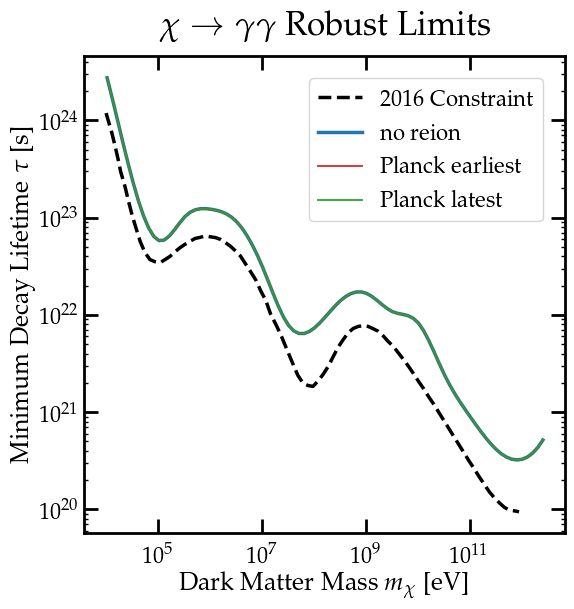

In [76]:
plt.figure()

plt.loglog()

# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_no_br, label='DH, no BR')
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_no_br_2016, label='DH, no BR, 2016 fs')
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_br, label='One Point', alpha=1, color='r')
# plt.plot(10**log10_m_chi_arr[:-4], 10**min_lifetime_photoion, label='DH, BR, photoion', color='green')
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_photoion_early, color='green')
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_photoion_middle, color='green')
# plt.plot(10**log10_m_chi_arr[:16], 10**tmp_list, color='purple', label=r'$\chi^2$')
# plt.plot(10**log10_m_chi_arr[:18], 10**np.array(tmp), color='green', label=r'$\chi^2$ with heating')
# plt.plot(10**log10_m_chi_arr[:16], 10**tmp_list2, color='purple', label=r'$\chi^2$')
plt.plot(constraint_data[:,0], constraint_data[:,1], color='k', linestyle = '--', label='2016 Constraint')

plt.plot(10**log10_mDM_fine, 
         10**interp1d(log10_m_chi_arr,min_lifetime_robust_noreion_chisq, kind='cubic')(log10_mDM_fine)
         , label='no reion'
        )
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_robust_noreion_chisq, label='no reion')
plt.plot(10**log10_mDM_fine,
         10**interp1d(log10_m_chi_arr,min_lifetime_robust_reion_early_chisq, kind='cubic')(log10_mDM_fine), 
         label='Planck earliest', linewidth=1.3, color='C3'
        )
plt.plot(10**log10_mDM_fine,
         10**interp1d(log10_m_chi_arr,min_lifetime_robust_reion_late_chisq, kind='cubic')(log10_mDM_fine), 
         label='Planck latest', linewidth=1.3, color='C2'
        )
plt.fill_between(10**log10_mDM_fine,
                  10**interp1d(log10_m_chi_arr,min_lifetime_robust_reion_late_chisq, kind='cubic')(log10_mDM_fine),
                  10**interp1d(log10_m_chi_arr,min_lifetime_robust_reion_early_chisq, kind='cubic')(log10_mDM_fine),
                  color='C3',
                  alpha=.5
                 )
# plt.plot(10**log10_m_chi_arr, 10**min_lifetime_2016_comparison, label='DH, no BR, HeII method', color='green')
# plt.plot(10**log10_m_chi_arr[:15], 10**min_lifetime_2016_with_br[:15], label='with BR', color='red')

# plt.axis([1e4,1e12,1e17,1e28])
plt.title(r'$\chi \to \gamma \gamma$ Robust Limits')#, $T_m(z=3.2) = 10^4$ K')
plt.ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.legend()
# plt.savefig('/Users/gridgway/Dropbox (MIT)/DM stuff/phot_decay_robust_limits.pdf')
plt.show()

# Electrons

In [344]:
log10_m_chi_arr = np.arange(6.01, 12.76, .5)

log10_mDM_fine = np.arange(6.01,12.51,.1)

In [334]:
Tm_elec_DeltaT_0_HII = pickle.load(open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_elec_decay_log10DeltaT_-inf_chisq_DeltaT_0_HII.dat','rb'))
min_lifetime_elec_DeltaT_0_HII = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_elec_DeltaT_0_HII, 2)

In [346]:
log10_mDM_fine

array([ 6.01,  6.11,  6.21,  6.31,  6.41,  6.51,  6.61,  6.71,  6.81,
        6.91,  7.01,  7.11,  7.21,  7.31,  7.41,  7.51,  7.61,  7.71,
        7.81,  7.91,  8.01,  8.11,  8.21,  8.31,  8.41,  8.51,  8.61,
        8.71,  8.81,  8.91,  9.01,  9.11,  9.21,  9.31,  9.41,  9.51,
        9.61,  9.71,  9.81,  9.91, 10.01, 10.11, 10.21, 10.31, 10.41,
       10.51, 10.61, 10.71, 10.81, 10.91, 11.01, 11.11, 11.21, 11.31,
       11.41, 11.51, 11.61, 11.71, 11.81, 11.91, 12.01, 12.11, 12.21,
       12.31, 12.41])

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


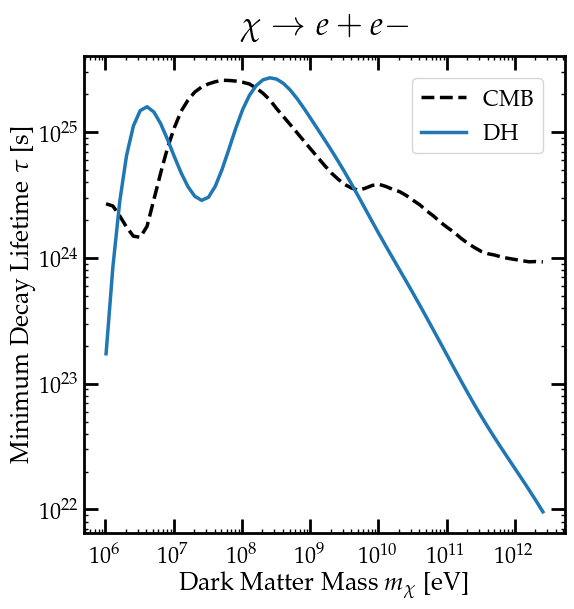

In [351]:
plt.figure()

plt.loglog()

plt.plot(10**log10_mDM_fine, xsec_bound_elec_CMB(10**log10_mDM_fine, 'decay'), color='k', linestyle = '--', label='CMB')

plt.plot(10**log10_mDM_fine, 
         10**interp1d(log10_m_chi_arr,min_lifetime_elec_DeltaT_0_HII, kind='cubic')(log10_mDM_fine)
         , label='DH'
        )


# plt.axis([1e4,1e12,1e17,1e28])
plt.title(r'$\chi \to e+e-$')#, $T_m(z=3.2) = 10^4$ K')
plt.ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.legend()
# plt.savefig('/Users/gridgway/Dropbox (MIT)/DM stuff/phot_decay_robust_limits.pdf')
plt.show()

In [326]:
np.arange(19.5, 26, 0.25).shape

(26,)

Let's do this now with backreaction. The backreaction calculation can be initialized using the $\tau$ value obtained without backreaction as an initial guess. That significantly narrows down the amount of scanning that needs to be done. Otherwise, it works in the same way as before, but it takes longer because the code needs to compute all of the spectra at each step. 

When using *main.evolve()* for the first time, the code will take some time to load all of the transfer functions required to perform this calculation.

array([2.69747958e+24, 2.58940246e+24, 2.16066251e+24, 1.75877221e+24,
       1.49129584e+24, 1.45967735e+24, 1.78384131e+24, 2.90580701e+24,
       4.74061042e+24, 7.49288188e+24, 1.08619693e+25, 1.46984070e+25,
       1.79783371e+25, 2.08779172e+25, 2.28807397e+25, 2.42224305e+25,
       2.51902842e+25, 2.58788578e+25, 2.57927434e+25, 2.55076860e+25,
       2.49778342e+25, 2.41786875e+25, 2.24599810e+25, 2.03959877e+25,
       1.80583856e+25, 1.53707719e+25, 1.32816321e+25, 1.14624469e+25,
       9.87375039e+24, 8.50244604e+24, 7.32399586e+24, 6.32228862e+24,
       5.45034697e+24, 4.74533823e+24, 4.23019041e+24, 3.82945906e+24,
       3.59268977e+24, 3.44895853e+24, 3.59035320e+24, 3.77449869e+24,
       3.85018181e+24, 3.70321261e+24, 3.51402643e+24, 3.36925399e+24,
       3.13562318e+24, 2.87245065e+24, 2.63670383e+24, 2.36468889e+24,
       2.15121174e+24, 1.92194857e+24, 1.74771687e+24, 1.59721998e+24,
       1.43473747e+24, 1.30821036e+24, 1.20825759e+24, 1.12542908e+24,
      

In [ ]:
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    
    # Get the estimate from min_lifetime_no_br
    j = np.where(log10_tau_arr > min_lifetime_no_br[i])[0][0]
    
    while (
        not below_target or not above_target
    ):

#         print('****************************')
        tau = 10**log10_tau_arr[j]
        
        Tm_dec_br[i,j] = get_T_decay(mDM, tau, br=True, pri=pri)
        print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_dec_br[i,j]))
             
        if Tm_dec_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a shorter lifetime.
            j -= 1
            
        elif Tm_dec_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a longer lifetime. 
            j += 1
            
# Save the data that was just produced
if save_data:
    pickle.dump(Tm_dec_br, open(direc+pri+'_decay_br.dat','wb'))

print('###### Calculation Complete! ######')

In [289]:
reion_rs=35
resultFlexKnot_early = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=1e12, lifetime=1e50,
    start_rs = 3000, end_rs=4.01,
    coarsen_factor=4, backreaction=True,
    reion_switch=True, reion_method=None, heat_switch=False, DeltaT=10**log10DeltaT_arr[3]*phys.kB,
    xe_reion_func=reion_interps['FlexKnot_early'],
    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
    helium_TLA=True
)

In [290]:
resultFlexKnot_late = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=1e12, lifetime=1e50,
    start_rs = 3000, end_rs=4.01,
    coarsen_factor=4, backreaction=True,
    reion_switch=True, reion_method=None, heat_switch=False, DeltaT=10**(log10DeltaT_arr[1]*.9+log10DeltaT_arr[2]*.1)*phys.kB,
    xe_reion_func=reion_interps['FlexKnot_late'],
    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
    helium_TLA=True
)

In [291]:
resultTanh_early = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=1e12, lifetime=1e50,
    start_rs = 3000, end_rs=4.01,
    coarsen_factor=4, backreaction=True,
    reion_switch=True, reion_method=None, heat_switch=False, DeltaT=10**log10DeltaT_arr[3]*phys.kB,
    xe_reion_func=reion_interps['Tanh_early'],
    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
    helium_TLA=True
)

In [292]:
resultTanh_late = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=1e12, lifetime=1e50,
    start_rs = 3000, end_rs=4.01,
    coarsen_factor=4, backreaction=True,
    reion_switch=True, reion_method=None, heat_switch=False, DeltaT=10**log10DeltaT_arr[2]*phys.kB,
    xe_reion_func=reion_interps['Tanh_late'],
    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
    helium_TLA=True
)

In [275]:
z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[-8:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[-8:]


errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
sigs = errs[-8:]

In [297]:
print(10**log10DeltaT_arr[3],
10**(log10DeltaT_arr[1]*.9+log10DeltaT_arr[2]*.1),
10**log10DeltaT_arr[3],
10**log10DeltaT_arr[2])

9976.311574844403 6441.2477584656735 9976.311574844403 7924.4659623055695


/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


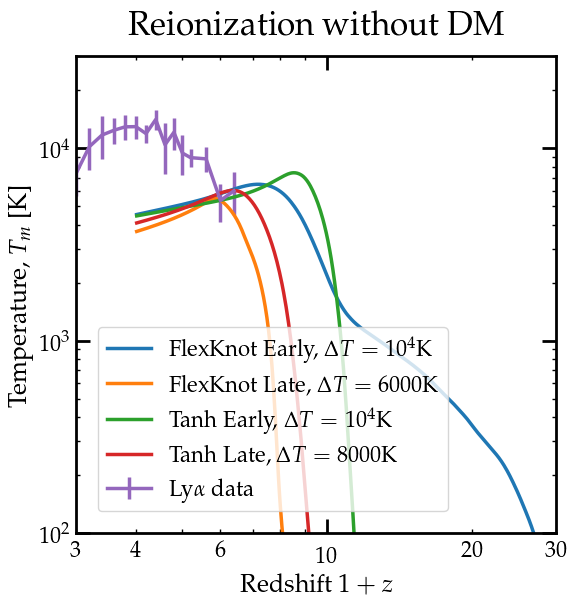

In [312]:
plt.figure()
plt.loglog()
plt.axis([3,30,1e2,3e4])
plt.plot(resultFlexKnot_early['rs'], resultFlexKnot_early['Tm']/phys.kB, label=r'FlexKnot Early, $\Delta T = 10^4$K')
plt.plot(resultFlexKnot_late['rs'], resultFlexKnot_late['Tm']/phys.kB, label=r'FlexKnot Late, $\Delta T = 6000$K')
plt.plot(resultTanh_early['rs'], resultTanh_early['Tm']/phys.kB, label=r'Tanh Early, $\Delta T = 10^4$K')
plt.plot(resultTanh_late['rs'], resultTanh_late['Tm']/phys.kB, label=r'Tanh Late, $\Delta T = 8000$K')
plt.errorbar(1+z_entries, new_mids*1e4, yerr=errs*1e4, label=r'Ly$\alpha$ data')

plt.xlabel(r'Redshift $1+z$')
plt.ylabel(r'Temperature, $T_m$ [K]')
plt.title('Reionization without DM')
plt.legend(loc=3)
plt.savefig('/Users/gridgway/Dropbox (MIT)/Late_Time_Energy_Injection/figs/max_DeltaT.pdf')
plt.show()

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


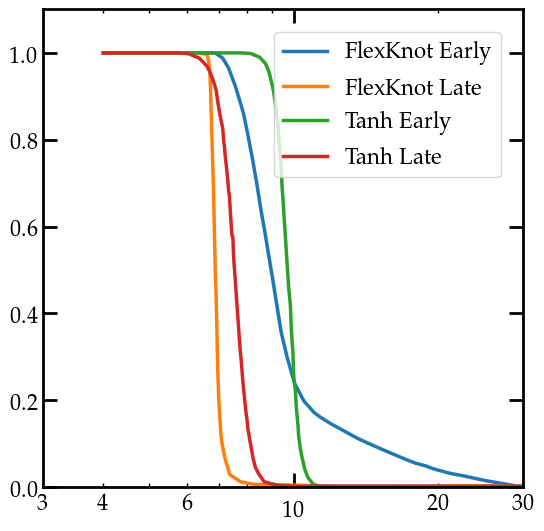

In [306]:
plt.figure()
plt.xscale('log')
plt.axis([3,30,1e-4,1.1])
plt.plot(resultFlexKnot_early['rs'], resultFlexKnot_early['x'][:,0], label='FlexKnot Early')
plt.plot(resultFlexKnot_late['rs'], resultFlexKnot_late['x'][:,0], label='FlexKnot Late')
plt.plot(resultTanh_early['rs'], resultTanh_early['x'][:,0], label='Tanh Early')
plt.plot(resultTanh_late['rs'], resultTanh_late['x'][:,0], label='Tanh Late')
# plt.errorbar(1+z_entries, new_mids*1e4, yerr=errs*1e4, label='data')

plt.legend()
plt.show()

In [284]:
%autoreload

reion_rs=35
if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

reion_method_list = ['FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']
chisq = True
constraint_type='DeltaT'


log10DeltaT_arr = np.arange(np.log10(5e3), np.log10(1e5), .1)
Tm_list = {reion_method: np.zeros((log10DeltaT_arr.size, rs_entries.size)) for reion_method in reion_method_list}

for i, reion_method in enumerate(tqdm(reion_method_list)):
    print('****** method: ', reion_method, ' ******')
    mDM = 10**log10mDM
    j = 0

    below_target = False
    above_target = False

    while (
        not below_target or not above_target
    ):

#         print('****************************')
        DeltaT = 10**log10DeltaT_arr[j]
        print('log10DeltaT: '+str(log10DeltaT_arr[j]))

        Tm_list[reion_method][j] = get_T_decay(
            mDM=1e12, tau=1e50, br=True, pri=pri, constraint_type=constraint_type, 
            chisq=chisq, 
            reion_method=reion_method, 
            heat_switch=heat_switch,
            DeltaT=DeltaT*phys.kB
        )
        if not chisq:
            print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[reion_method][j]))
        else:
            diff = Tm_list[reion_method][j]*1e-4 - mids
            diff[diff<0] = 0
            DoF = sum(diff>0)
            if DoF == 0:
                reduced = 0
            else:
                reduced = sum((diff/sigs)**2)/DoF
            print('one-sided reduced chi^2: {:03.1e}'.format(reduced))

            nan_flag = np.any(np.isnan(Tm_list[reion_method][j]))

        if not chisq:
            if Tm_list[reion_method][j] <= Tm_max:

                below_target = True
                # Below target T_m means we need a shorter lifetime.
                j += 1

            elif Tm_list[reion_method][j] >= Tm_max:

                above_target = True
                # Above target T_m means we need a longer lifetime. 
                j -= 1
        else:
            if nan_flag:
                print('NAN! increasing heating rate.')
                j += 1
            elif reduced < 2:
                below_target = True
                j += 1
            elif reduced > 2:
                above_target = True
                j-=1

            if chisq:
                chi_str = 'chisq'
            else:
                chi_str=''
        pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_DeltaT_max_log10DeltaT_'+str(log10DeltaT_arr[j])+'.dat','wb'))
        print('###### Calculation Complete! ######')  

###### Target Reduced chi^2: 2  ######


****** method:  FlexKnot_early  ******
log10DeltaT: 3.6989700043360187


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.798970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.898970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.998970004336019


one-sided reduced chi^2: 7.4e-02
###### Calculation Complete! ######
log10DeltaT: 4.098970004336019


one-sided reduced chi^2: 1.2e+00
###### Calculation Complete! ######
log10DeltaT: 4.198970004336019


one-sided reduced chi^2: 4.3e+00
###### Calculation Complete! ######
****** method:  FlexKnot_late  ******
log10DeltaT: 3.6989700043360187


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.798970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.898970004336019


one-sided reduced chi^2: 8.3e-01
###### Calculation Complete! ######
log10DeltaT: 3.998970004336019


one-sided reduced chi^2: 2.4e+00
###### Calculation Complete! ######
****** method:  Tanh_early  ******
log10DeltaT: 3.6989700043360187


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.798970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.898970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.998970004336019


one-sided reduced chi^2: 1.5e-04
###### Calculation Complete! ######
log10DeltaT: 4.098970004336019


one-sided reduced chi^2: 3.6e-01
###### Calculation Complete! ######
log10DeltaT: 4.198970004336019


one-sided reduced chi^2: 2.0e+00
###### Calculation Complete! ######
log10DeltaT: 4.298970004336019


one-sided reduced chi^2: 5.0e+00
###### Calculation Complete! ######
****** method:  Tanh_late  ******
log10DeltaT: 3.6989700043360187


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.798970004336019


one-sided reduced chi^2: 0.0e+00
###### Calculation Complete! ######
log10DeltaT: 3.898970004336019


one-sided reduced chi^2: 8.5e-02
###### Calculation Complete! ######
log10DeltaT: 3.998970004336019


one-sided reduced chi^2: 1.5e+00
###### Calculation Complete! ######
log10DeltaT: 4.098970004336019


one-sided reduced chi^2: 5.9e+00
###### Calculation Complete! ######



In [288]:
np.transpose(np.array([10**log10DeltaT_arr,Tm_list['FlexKnot_early'][:,0]]))

array([[ 5000.        ,  2998.0585063 ],
       [ 6294.62705897,  3492.68323221],
       [ 7924.46596231,  4067.66727252],
       [ 9976.31157484,  4737.03323745],
       [12559.43215755,  5516.30360273],
       [15811.38830084,  6417.16574602],
       [19905.35852767,     0.        ],
       [25059.36168136,     0.        ],
       [31547.86722401,     0.        ],
       [39716.41173621,     0.        ],
       [50000.        ,     0.        ],
       [62946.27058971,     0.        ],
       [79244.65962306,     0.        ],
       [99763.11574844,     0.        ]])

In [246]:
np.transpose(np.array([10**log10DeltaT_arr,Tm_list['Tanh_early'][:,0]]))

array([[ 8000.        ,  3719.42284584],
       [10071.40329435,  4295.45625978],
       [12679.14553969,  4956.12400825],
       [15962.09851975,  5713.29309771],
       [20095.09145208,  6580.59939539],
       [25298.22128135,  7573.46604141],
       [31848.57364428,  8709.24652299],
       [40094.97869018, 10009.83414171],
       [50476.58755842, 11502.70500013],
       [63546.25877794,     0.        ],
       [80000.        ,     0.        ]])

### Annihilating Dark Matter

Annihilating dark matter sensitivity can also be evaluated in a very similar manner. The only difference here is that structure formation now boosts the annihilation rate at late times. We can load one of DarkHistory's default structure formation boost factors that can be obtained using the function [*physics.struct_boost_func()*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.struct_boost_func.html). The first thing we need to do is obtain the function that returns the boost: 

In [ ]:
struct_boost_einasto_subs = phys.struct_boost_func(model='einasto_subs')

We can now define the analogous *get_T_swave* function with this structure formation prescription included with the keyword *struct_boost* passed to [*main.evolve()*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html):

In [ ]:
%autoreload 2
def get_T_swave(mDM, sigmav, br, pri):
    """Gets the temperature at z = 17, s-wave annihilation.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    sigmav : float
        The annihilation cross-section in cm^-3 s^-1.  
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature in K at z = 17. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 12
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 4
        
    if br:
    
        result = main.evolve(
            primary=pri_str,
            DM_process='swave', mDM=mDM, sigmav=sigmav,
            start_rs = 3000, end_rs=18,
            coarsen_factor=cf, backreaction=True,
            struct_boost=struct_boost_einasto_subs
        )
        
        return result['Tm'][-1]/phys.kB
    
    else:
        # get_history takes a redshift vector 
        rs_vec = np.flipud(np.arange(18, 3000., 0.1))
        
        result = get_history(
            rs_vec, baseline_f = True,
            inj_particle = pri, DM_process = 'swave',
            mDM=mDM, sigmav = sigmav,
            struct_boost=None
        )
        
        return result[-1,0]/phys.kB

Now initialize the data! We use $\langle \sigma v \rangle / m_\chi$ as the range to scan over, since this quantity determines the energy injection rate.

In [ ]:
pri = 'phot'

In [ ]:
if pri == 'phot':
    log10_m_chi_arr = np.arange(4, 12.75, 0.25)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, 0.25)
log10_sigmav_over_m_arr   = np.arange(-29, -22, 0.25)

Tm_ann_no_br = np.zeros((log10_m_chi_arr.size, log10_sigmav_over_m_arr.size))
Tm_ann_br = np.zeros_like(Tm_ann_no_br)

And start the scan!

In [ ]:
%autoreload
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    if i == 0:
        j = 0
    
    while (
        not below_target or not above_target
    ):

        sigmav = 10**log10_sigmav_over_m_arr[j]*mDM/1e9
        
        Tm_ann_no_br[i,j] = get_T_swave(mDM, sigmav, br=False, pri=pri)
        print('sigmav: {:03.1e}'.format(sigmav), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_ann_no_br[i,j]))
             
        if Tm_ann_no_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a larger sigmav.
            j += 1
            
        elif Tm_ann_no_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a smaller sigmav. 
            j -= 1

# Save the data that was just produced
if save_data:
    pickle.dump(Tm_ann_no_br, open(direc+pri+'_swave_no_br.dat','wb'))

print('###### Calculation Complete! ######')        

As above, we use a simple linear interpolation to determine the maximum $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ over our list of dark matter masses and store the result in `max_xsec_no_br`,

In [ ]:
def get_log10_max_xsec(log10_sigmav_over_m_arr, Tm_arr, max_Tm):
    """Returns the log10 maximum sigma v over m from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 sigma v over m's used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    # Find the first index at which we have Tm < max_Tm in Tm_arr. 
    below = np.where((Tm_arr > 0) & (Tm_arr < max_Tm))[0][-1]
    # Since increasing lifetime decreases Tm, the next index must
    # lie below max_Tm.
    above = below+1
    
    # Obtain the two temperature values. 
    Ts = [Tm_arr[below], Tm_arr[above]]
    # Obtain the two log10 lifetime values. 
    log10_xsecs = [log10_sigmav_over_m_arr[below], log10_sigmav_over_m_arr[above]]
    
    # Perform a linear interpolation.
    return (np.diff(log10_xsecs)/np.diff(Ts)*(max_Tm-Ts[0]) + log10_xsecs[0])[0]

max_xsec_no_br = np.array(
    [get_log10_max_xsec(log10_sigmav_over_m_arr, row, Tm_max) for row in Tm_ann_no_br]
)

and then we plot $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ as a function of $m_\chi$

In [ ]:
plt.figure()

plt.loglog()

plt.plot(10**log10_m_chi_arr/10**9, 10**(max_xsec_no_br))

if pri == 'phot':
    plt.axis([1e-5,2e3,3e-27,1.5e-25])
else:
    plt.axis([1e-3,2e3,5e-29,1.5e-25])

plt.title(r'$\chi\chi \to \gamma \gamma$ Limits, $T_{21} = -50$ mK')
plt.ylabel(r'Maximum $\langle \sigma v \rangle$ / $m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

and finally compute $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ including back-reaction

In [ ]:
%autoreload
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    j = np.where(log10_sigmav_over_m_arr > max_xsec_no_br[i])[0][0]
    
    while (
        not below_target or not above_target
    ):

        sigmav = 10**log10_sigmav_over_m_arr[j] * mDM/1e9
        
        Tm_ann_br[i,j] = get_T_swave(mDM, sigmav, br=True, pri=pri)
        print('sigmav/m: {:03.1e}'.format(sigmav/mDM), ' T(z = 17) w/ backreaction: {:03.1f} K'.format(Tm_ann_no_br[i,j]))
             
        if Tm_ann_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a larger sigmav.
            j += 1
            
        elif Tm_ann_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a smaller sigmav. 
            j -= 1
            
# Save the data that was just produced
if save_data:
    pickle.dump(Tm_ann_br, open(direc+pri+'_swave_br.dat','wb'))

print('###### Calculation Complete! ######')

## Plotting

In this final section, we show the user how to plot the 21cm Sensitivity as is done in Fig. 6 of paper I.  We assume that the user has at some point run this notebook with `save_data=True` so that the data has been saved in the directory `direc=/directory/where/the/data/gets/saved/` as described above.

In [ ]:
inj_type = 'decay'
pri = 'phot'
direc = '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/'

then load the raw temperature data as a function of $m_\chi$ and $\tau$ or $\langle \sigma v \rangle$,

In [ ]:
Tm_no_br = pickle.load(open(direc+pri+'_'+inj_type+'_no_br.dat','rb'))
Tm_br    = pickle.load(open(direc+pri+'_'+inj_type+'_br.dat','rb'))

then process the data to the $\tau$ or $\langle \sigma v \rangle$ bounds as a function of $m_\chi$,

In [ ]:
if inj_type == 'decay':
    log10_tau_arr   = np.arange(23., 28.25, 0.25)
    thresh_params_std = np.array(
        [get_log10_min_lifetime(log10_tau_arr, row, Tm_max) for row in Tm_no_br]
    )

    thresh_params_BR = np.array(
        [get_log10_min_lifetime(log10_tau_arr, row, Tm_max) for row in Tm_br]
    )
else:
    log10_sigmav_over_m_arr = np.arange(-29, -22, 0.25)
    thresh_params_std = np.array(
        [get_log10_max_xsec(log10_sigmav_over_m_arr, row, Tm_max) for row in Tm_no_br]
    )

    thresh_params_BR = np.array(
        [get_log10_max_xsec(log10_sigmav_over_m_arr, row, Tm_max) for row in Tm_br]
    )

### Plots

Make an interpolation function for the points $(m_\text{DM}, \tau_\text{min})$ or $(m_\text{DM}, \sigma_\text{max})$ with and without backreaction.

In [ ]:
if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, 0.25)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, 0.25)

In [ ]:
std_interp = interp1d(log10_m_chi_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10_m_chi_arr, thresh_params_BR, kind='quadratic')

log10mDM_arr_fine = np.arange(log10_m_chi_arr[0], log10_m_chi_arr[-1], .01)

In [ ]:
plt.figure()
ax = plt.gca()
ax.loglog()

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if pri=='electron':
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \chi \to e^+ e^-$')
        ymin = 3e-29
        ymax = 1e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e^+ e^-$')
        ymin = 1e24
        ymax = 5e28
else:
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi\chi \to \gamma\gamma$')
        ymin = 3e-27
        ymax = 1.5e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma\gamma$')
        ymin = 2e23
        ymax = 4e26
    
plt.xlabel(r'Dark Matter Mass $m_\chi$ [GeV]')
if inj_type == 'swave':
    plt.ylabel(r'Maximum $\langle \sigma v \rangle / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
else:
    plt.ylabel(r'Minimum Lifetime $\tau \, [\mathrm{s}]$')
    
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=1, label='No Backreaction', color='#6a176e', linestyle='--')
plt_BR, = plt.plot(10**log10mDM_arr_fine/10**8.93, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='With Backreaction', color='#f37819')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**std_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='#6a176e',
    alpha=0.2
)

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='#f37819',
    alpha=.1
)

if inj_type == 'swave':
    plt.text(0.52, 0.22, r'$T_{21}$ = $-50$ mK', fontsize=20, transform=ax.transAxes) 
else:
    plt.text(0.49, 0.89, r'$T_{21}$ = $-50$ mK', fontsize=20, transform=ax.transAxes)

if inj_type == 'swave':
    if inj_str == 'phot':
        leg = plt.legend(handles=[plt_std, plt_BR])
    else:
        leg = plt.legend(handles=[plt_std, plt_BR], loc='lower right')
else:
    leg = plt.legend(handles=[plt_std, plt_BR], loc=(0.4, 0.72))

## Bibliography

[1]<a id='cite_EDGES'></a> Judd D. Bowman, Alan E. E. Rogers, Raul A. Monsalve, Thomas J. Mozdzen, and Nivedita Mahesh, “An absorption profile centred at 78 megahertz in the sky-averaged spectrum,” Nature 555, 67–70 (2018).